In [1]:
import numpy as np

In [2]:
np.random.seed = 42

data = np.load('./data/dataset-v3.npz')
np.unique(data['labels'])

array([0, 1, 2, 3, 4, 5, 6])

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
train_images, test_images, train_labels, test_labels = train_test_split(data['data'], data['labels'], test_size=0.7, stratify=data['labels'], random_state=42)

In [5]:
len_test = len(test_labels)
len_train = len(train_labels)
print(len_test, len_train)

1417 606


In [6]:
train_images.dtype

dtype('uint8')

In [7]:
train_labels.dtype

dtype('int64')

In [8]:
import matplotlib.pyplot as plt

In [9]:
index = 22
item = train_images[index]
print('Result:', train_labels[index])

Result: 2


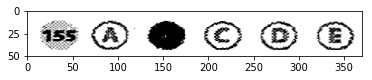

In [10]:
plt.imshow(item, cmap=plt.cm.binary_r)
plt.show()

In [11]:
from keras.utils import to_categorical

/home/kleber/anaconda3/envs/tensorflow-cpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
train_images = train_images.reshape((len_train, 50, 370, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((len_test, 50, 370, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels).astype('float32')
test_labels = to_categorical(test_labels).astype('float32')

In [13]:
train_images.dtype, train_labels.dtype

(dtype('float32'), dtype('float32'))

In [14]:
from keras import layers
from keras import models
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(layers_out=[64,32,32,128], activation='relu', last_activation='softmax', optimizer='Adamax', conv_map=[(16, 16), (8, 8), (4, 4)], dropout=.3):
    model = models.Sequential()
    
    model.add(layers.Conv2D(layers_out[0], conv_map[0], activation=activation, input_shape=(50, 370, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout))
    
    model.add(layers.Conv2D(layers_out[1], conv_map[1], activation=activation))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout))
    
    model.add(layers.Conv2D(layers_out[2], conv_map[2], activation=activation))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout))
    
    model.add(layers.Flatten())    
    model.add(layers.Dense(layers_out[3], activation=activation))    
    
    model.add(layers.Dense(7, activation=last_activation))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = KerasClassifier(build_fn=create_model, verbose=2)

epochs = [4]
batch_size = [4]
conv_map = [[(16, 16), (8, 8), (4, 4)], [(8, 8), (4, 4), (2, 2)], [(4, 4), (3, 3), (2, 2)], [(4, 4), (4, 4), (2, 2)]]

param_grid = dict(batch_size=batch_size, 
                  epochs=epochs,                   
                  conv_map=conv_map
                 )

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=4)

In [ ]:
grid_result = grid.fit(train_images, train_labels)

Epoch 1/4
Epoch 1/4
Epoch 1/4
Epoch 1/4
 - 94s - loss: 1.6653 - acc: 0.3762
Epoch 2/4


In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))